In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ENTROPY
• this is a measure of disorder.
• Value: between 0 (= order) and 1 (total disorder)

In [58]:
def entropy(column: pd.Series, base=None) -> float:
    """
    Compute the entropy of a pandas Series.
    :param column: column passed
    :param base: logarithmic base
    :return: entropy value
    """

    fracties = column.value_counts(normalize=True, sort=False)
    base = 2 if base is None else base
    return -(fracties * np.log(fracties) / np.log(base)).sum()

# INFORMATION GAIN
• Reflects the gain in terms of order
• The greater, the less disorder

In [59]:
def information_gain(df: pd.DataFrame, s: str, target: str) -> float:
    """
    Compute the information gain of a data frame.
    :param df: data frame
    :param s: column to compute the information gain
    :param target: target column
    :return:
    """
    # calculate entropy of parent table
    entropy_parent = entropy(df[target])
    child_entropies = []
    child_weights = []
    # compute entropies of child tables
    for (label, p) in df[s].value_counts().items():
        child_df = df[df[s] == label]
        child_entropies.append(entropy(child_df[target]))
        child_weights.append(int(p))
    # calculate the difference between parent entropy and weighted child entropies
    return entropy_parent - np.average(child_entropies, weights=child_weights)

# SPLIT

In [60]:
def best_split(df: pd.DataFrame, target: str) -> (str, float):
    """
    Find the best split of a data frame.
    :param df: data frame
    :param target:  target column
    :return:
    """
    # retrieve all non-target column labels (the features))
    features = df.drop(axis=1, labels=target).columns
    # calculate the information gains for these features
    gains = [information_gain(df, feature, target) for feature in features]
    # return column with highest information gain
    return features[np.argmax(gains)], max(gains)

# EXAMPLES
------------------------------------------

In [61]:
simpsons = pd.read_csv("The Simpsons.csv")
entropy(simpsons.gender)

0.9910760598382221

In [62]:
for label in simpsons.drop(labels='gender', axis=1).columns:
    print('{}: {}'.format(label, information_gain(simpsons, label, 'gender')))

name: 0.9910760598382221
hair length: 0.45165906291896163
weight: 0.5900048960119098
age: 0.07278022578373256


In [63]:
simpsons

,name,hair length,weight,age,gender
0,Homer,<3,>160,30-40,M
1,Marge,>5,<=160,30-40,F
2,Bart,<3,<=160,<30,M
3,Lisa,>5,<=160,<30,F
4,Maggie,3-5,<=160,<30,F
5,Abe,<3,>160,>40,M
6,Selma,>5,<=160,>40,F
7,Otto,>5,>160,30-40,M
8,Krusty,>5,>160,>40,M


In [64]:
import graphviz
import six
import sys

sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz, export_text

model = Id3Estimator()
# X - FEATURES          Y - TARGET
X = simpsons.drop(['name', 'gender'], axis=1).values.tolist()
y = simpsons['gender'].values.tolist()
model.fit(X, y)
print(export_text(model.tree_, feature_names=simpsons.drop(['name', 'gender'], axis=1).columns))


weight <=160
|   hair length 3-5: F (1) 
|   hair length <3: M (1) 
|   hair length >5: F (3) 
weight >160: M (4) 



In [68]:
# export decision tree to disk
export_graphviz(model.tree_, 'tree.dot', feature_names=
simpsons.drop(['name', 'gender'], axis=1).columns)
# visualize decision tree
graphviz.Source.from_file('tree.dot')
!dot -Tpng tree.dot -o tree.png
img = plt.imread('tree.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

TypeError: 'NoneType' object is not callable

TypeError: 'NoneType' object is not callable

In [66]:
 # what about Comic? How to predict the Gender?

Z = np.array([['>5', '>160', '30-40']])  # features of Comic
model.predict(Z)
# predict – check if all persons fall into the right catagory
model.predict(X)
#% of test cases that are correctly classified
100 * (model.predict(X) == simpsons.gender).count() / len(X)

100.0

[Text(0.6, 0.8333333333333334, 'weight <= 165.0\nentropy = 0.991\nsamples = 9\nvalue = [4, 5]\nclass = cluster M'),
 Text(0.4, 0.5, 'hair length <= 3.0\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]\nclass = cluster F'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = cluster M'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = cluster F'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = cluster M')]

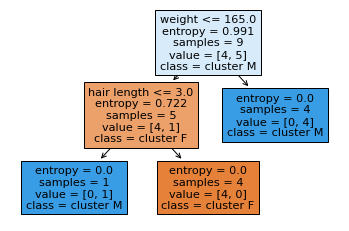

In [67]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

simpsons = pd.read_csv("The Simpsons original.csv")
classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(simpsons.drop(['gender', 'name'], axis=1), simpsons['gender'])
tree.plot_tree(classifier, feature_names=simpsons.drop(['gender', 'name'], axis=1).columns.values,
               class_names=['cluster {}'.format(i)
                            for i in np.unique(simpsons['gender'])], filled=True)